# Moving Averages CINGULATE region

### 1) Imports

In [1]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from datasets import SkeletonDataset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics

import matplotlib.cm as cm

In [3]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(1, len(df.columns)+1)]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [4]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

### 2) Loading of subjects's distribution in the latent space
DataFrame is obtained during analysis of beta-VAE latent space (2 dimensions) for CINGULATE crops, according to the following steps:
- loading of trained model
- encoding of test controls and asymmetry benchmark subjects

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"

In [6]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/gridsearch/n_4_kl_2/'
model = VAE((1, 20, 40, 40), 4, depth=3)
model.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model = model.to(device)

In [7]:
subject_dir = "/neurospin/dico/data/deep_folding/current/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/"

train_list = pd.read_csv(os.path.join(subject_dir,
                         f"HCP_half_{1}bis.csv"), header=None,
                         usecols=[0], names=['subjects'])

train_list['subjects'] = train_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(train_list, left_on = tmp.index, right_on='subjects', how='right')

filenames = list(train_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames)

In [8]:
dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=64,
              num_workers=8,
              shuffle=True)    

In [9]:
dico_set_loaders = {'data': dataloader}

root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/n_4_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3, root_dir=root_dir)

In [18]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['data']
X = np.array(list(df_encoded['latent']))
labels = list(results['data'].keys())

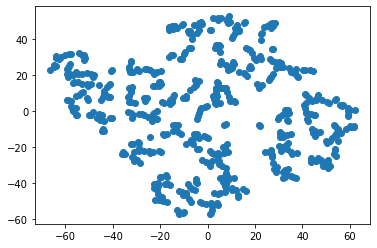

In [19]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=8, random_state=12).fit_transform(X)

x = [X_embedded[k][0] for k in range(len(X_embedded))]
y = [X_embedded[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

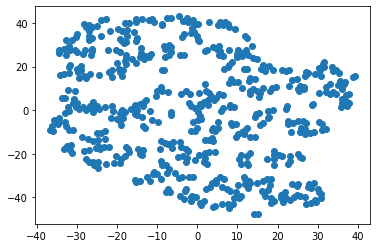

In [20]:
X_embedded1 = TSNE(n_components=2, perplexity=15).fit_transform(X)

x = [X_embedded1[k][0] for k in range(len(X_embedded))]
y = [X_embedded1[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [13]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [21]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(X_embedded1)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X_embedded1)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X_embedded1[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X_embedded1)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

20
4
cluster's centroids coordinates: 
 [[-15.615232  -1.578265]
 [-14.208929  24.443424]
 [ 13.193595  14.576938]
 [ 11.798972 -33.726078]]


In [22]:
dstrb_sub = pd.DataFrame(X_embedded1, index=labels, columns=[1, 2])
dstrb_sub['cluster_lab'] = x_cluster_label

In [23]:
cluster1 = dstrb_sub[dstrb_sub.cluster_lab==0]
cluster2 = dstrb_sub[dstrb_sub.cluster_lab==1]
cluster3 = dstrb_sub[dstrb_sub.cluster_lab==2]
cluster4 = dstrb_sub[dstrb_sub.cluster_lab==3]
assert(len(np.unique(list(cluster1.cluster_lab)))==1)
assert(len(np.unique(list(cluster2.cluster_lab)))==1)
assert(len(np.unique(list(cluster3.cluster_lab)))==1)
assert(len(np.unique(list(cluster4.cluster_lab)))==1)

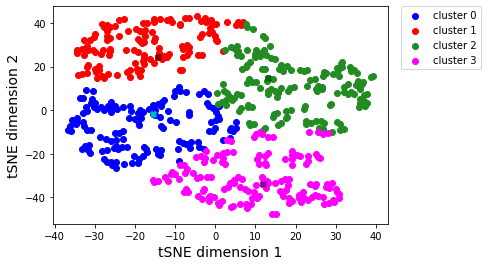

In [24]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='c', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='maroon', marker='X')
ax.scatter(clusters_centroids[2][0], clusters_centroids[2][1], color='darkgreen', marker='X')
ax.scatter(clusters_centroids[3][0], clusters_centroids[3][1], color='darkmagenta', marker='X')
#ax.scatter(cc1[0], cc1[1], color='crimson', marker='X')
#ax.scatter(cc2[0], cc2[1], color='maroon', marker='X')
#ax.scatter(cc3[0], cc3[1], color='darkgreen', marker='X')
#ax.scatter(cc4[0], cc4[1], color='navy', marker='X')
#ax.scatter(dstrb_sub[1]['208125'], dstrb_sub[2]['208125'], color='forestgreen')
#ax.scatter(dstrb_sub[1]['133827'], dstrb_sub[2]['133827'], color='forestgreen')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [18]:
central_1 = closest_distance(clusters_centroids[0], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 1 is {central_1}")
central_2 = closest_distance(clusters_centroids[1], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 2 is {central_2}")
central_3 = closest_distance(clusters_centroids[2], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 3 is {central_3}")
central_4 = closest_distance(clusters_centroids[3], dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster 4 is {central_4}")

Closest subject to centroid of cluster 1 is 169141
Closest subject to centroid of cluster 2 is 111312
Closest subject to centroid of cluster 3 is 131217
Closest subject to centroid of cluster 4 is 191336


### Creation of buckets dictionnary

In [19]:
bucket_path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rbuckets/'
suffix_path = '_normalized.bck'
buckets = {}
for sub in tqdm(list(labels)):
    bucket = aims.read(os.path.join(bucket_path, str(sub) + suffix_path))
    bucket = dtx.convert.bucket_aims_to_ndarray(bucket[0])
    buckets[sub] = bucket

100%|██████████| 550/550 [00:34<00:00, 15.94it/s]


In [20]:
subjects_c1 = cluster1.index
subjects_c2 = cluster2.index
subjects_c3 = cluster3.index
subjects_c4 = cluster4.index

buckets_c1 = {k: v for k,v in buckets.items() if k in list(subjects_c1)}
buckets_c2 = {k: v for k,v in buckets.items() if k in list(subjects_c2)}
buckets_c3 = {k: v for k,v in buckets.items() if k in list(subjects_c3)}
buckets_c4 = {k: v for k,v in buckets.items() if k in list(subjects_c4)}

#### Alignement of the subjects to respective central subject

In [21]:
aligned_buckets_C1, aligned_rot_C1, aligned_transl_C1 = ma.align_buckets_by_ICP_batch(buckets_c1, central_1)
aligned_buckets_C2, aligned_rot_C2, aligned_transl_C2 = ma.align_buckets_by_ICP_batch(buckets_c2, central_2)
aligned_buckets_C3, aligned_rot_C3, aligned_transl_C3 = ma.align_buckets_by_ICP_batch(buckets_c3, central_3)
aligned_buckets_C4, aligned_rot_C4, aligned_transl_C4 = ma.align_buckets_by_ICP_batch(buckets_c4, central_4)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 169141: 100%|██████████| 123/123 [00:01<00:00, 93.14it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 111312: 100%|██████████| 105/105 [00:01<00:00, 80.87it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 131217: 100%|██████████| 178/178 [00:01<00:00, 95.44it/s]
>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 191336: 100%|██████████| 144/144 [00:01<00:00, 91.66it/s]


In [22]:
def subj_count_extreme_coords(isodf, axis, min_coord, max_coord, num_coord=5):
    coord_values = np.linspace(min_coord, max_coord, num_coord)
    step = (coord_values[1] - coord_values[0])
    midpoint_min = coord_values[0] + step/2
    midpoint_max = coord_values[num_coord-1] - step/2
    coord_under = [elt for elt in isodf[axis] if elt<midpoint_min]
    coord_over = [elt for elt in isodf[axis] if elt>midpoint_max]
    num_subj_under = len(coord_under)
    num_subj_over = len(coord_over)
    return num_subj_under, num_subj_over

def get_MA_coords(isodf, axis, num_subj_threshold, num_coord=5):
    min_subj_coord = min(isodf[axis])
    max_subj_coord = max(isodf[axis])
    step = (max_subj_coord - min_subj_coord)/num_coord
    num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord, num_coord)
    while ((num_subj_under<num_subj_threshold)|(num_subj_over<num_subj_threshold)):
        step = (max_subj_coord - min_subj_coord)/num_coord
        if num_subj_under<num_subj_threshold:
            min_subj_coord = min_subj_coord + step
        if num_subj_over<num_subj_threshold:
            max_subj_coord = max_subj_coord - step
        num_subj_under, num_subj_over = subj_count_extreme_coords(isodf, axis, min_subj_coord, max_subj_coord)
    return np.linspace(min_subj_coord, max_subj_coord, num_coord)

### TSNE AXIS 1 analysis

In [23]:
MA_coords_1 = [dstrb_sub.loc[central_1][1]]
MA_coords_2 = [dstrb_sub.loc[central_2][1]]
MA_coords_3 = [dstrb_sub.loc[central_3][1]]
MA_coords_4 = [dstrb_sub.loc[central_3][1]]

#### Parameters

In [32]:
axis = 1

#### Cluster 1

In [33]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords_1, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=20)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


In [34]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.4, threshold=0.56)
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 104.67it/s]


#### Cluster 2

In [35]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=20)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [36]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.4, threshold=0.56,smoothRate=0.6)
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 117.29it/s]


#### Cluster 3

In [37]:
SPAM_vols_c3, shift3 = ma.calc_MA_volumes_batch(MA_coords_3, aligned_buckets_C3, cluster3, axis_n=axis, FWHM=20)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


In [38]:
SPAM_meshes_3 = {}

for k, volume in tqdm(list(SPAM_vols_c3.items())[:]):
    SPAM_meshes_3[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.4, threshold=0.62, smoothRate=0.4)
    
shifted_SPAM_meshes_3 = {}
for dist, mesh in SPAM_meshes_3.items():
    shifted_SPAM_meshes_3[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_3.items()):
    aims.write(mesh, f"MA_cluster_3.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 112.48it/s]


#### Cluster 4

In [39]:
SPAM_vols_c4, shift4 = ma.calc_MA_volumes_batch(MA_coords_4, aligned_buckets_C4, cluster4, axis_n=axis, FWHM=20)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [40]:
SPAM_meshes_4 = {}

for k, volume in tqdm(list(SPAM_vols_c4.items())[:]):
    SPAM_meshes_4[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.4, threshold=0.5)
    
shifted_SPAM_meshes_4 = {}
for dist, mesh in SPAM_meshes_4.items():
    shifted_SPAM_meshes_4[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_4.items()):
    aims.write(mesh, f"MA_cluster_4.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 124.47it/s]


## Replication with model trained on HCP half 2

In [24]:
model_dir = '/neurospin/dico/lguillon/midl_22/new_design/half2/n_4_kl_2/'
model_2 = VAE((1, 20, 40, 40), 4, depth=3)
model_2.load_state_dict(torch.load(model_dir + 'checkpoint.pt'))
model_2 = model_2.to(device)

In [25]:
root_dir = '/neurospin/dico/lguillon/midl_22/new_design/analysis/model_2_n_4_kl_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model_2, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3, root_dir=root_dir)

In [26]:
results_2 = tester.test()
encoded_2 = {loader_name:[results_2[loader_name][k] for k in results_2[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
df_encoded_2 = pd.DataFrame()
df_encoded_2['latent'] = encoded_2['data']
X_2 = np.array(list(df_encoded_2['latent']))
labels_2 = list(results_2['data'].keys())

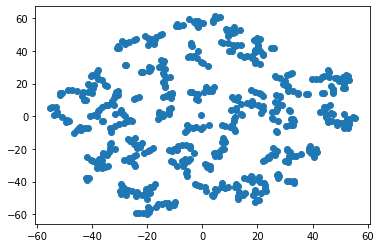

In [27]:
from sklearn.manifold import TSNE
X_embedded_2 = TSNE(n_components=2, perplexity=8).fit_transform(X_2)

x = [X_embedded_2[k][0] for k in range(len(X_embedded_2))]
y = [X_embedded_2[k][1] for k in range(len(X_embedded_2))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

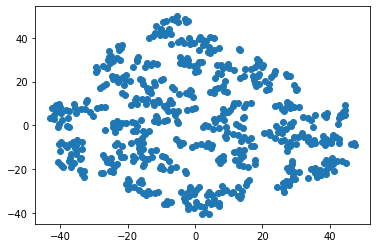

In [28]:
X_embedded1_2 = TSNE(n_components=2, perplexity=15).fit_transform(X_2)

x = [X_embedded1_2[k][0] for k in range(len(X_embedded1_2))]
y = [X_embedded1_2[k][1] for k in range(len(X_embedded1_2))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [29]:
dstrb_sub_2 = pd.DataFrame(X_embedded1_2, index=labels_2, columns=[1, 2])

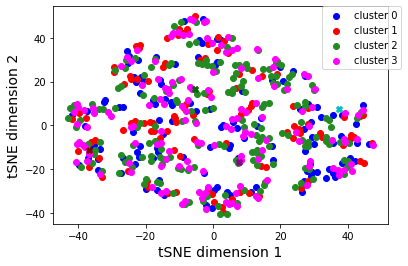

In [30]:
arr = np.array([np.array([dstrb_sub_2[k][i] for k in dstrb_sub_2.columns[:2]]) for i in range(len(dstrb_sub_2))])

color_dict = {0:'blue',1: 'red', 2:'forestgreen', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.cluster_lab]):
    ix = np.where(dstrb_sub.cluster_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"cluster {g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
ax.scatter(clusters_centroids[0][0], clusters_centroids[0][1], color='c', marker='X')
ax.scatter(clusters_centroids[1][0], clusters_centroids[1][1], color='maroon', marker='X')
ax.scatter(clusters_centroids[2][0], clusters_centroids[2][1], color='darkgreen', marker='X')
ax.scatter(clusters_centroids[3][0], clusters_centroids[3][1], color='darkmagenta', marker='X')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

### TSNE AXIS 2 analysis

In [266]:
MA_coords_1_2 = [dstrb_sub.loc[central_1][2]]
MA_coords_2_2 = [dstrb_sub.loc[central_2][2]]
MA_coords_3_2 = [dstrb_sub.loc[central_3][2]]
MA_coords_4_2 = [dstrb_sub.loc[central_3][2]]

#### Parameters

In [268]:
fwhm = 0.8
thresh = 90
axis = 2

#### Cluster 1

In [269]:
SPAM_vols_c1_2, shift1_2 = ma.calc_MA_volumes_batch(MA_coords_1_2, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=0.5)

Calculating moving averages: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [278]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1_2.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{91}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1_dim2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 105.13it/s]


#### Cluster 2

In [283]:
SPAM_vols_c2_2, shift2_2 = ma.calc_MA_volumes_batch(MA_coords_2_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=1.5)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


In [286]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{91}%")
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2_dim2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 123.70it/s]


#### Cluster 3

In [287]:
SPAM_vols_c3_2, shift3_2 = ma.calc_MA_volumes_batch(MA_coords_3_2, aligned_buckets_C3, cluster3, axis_n=axis, FWHM=1.5)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


In [288]:
SPAM_meshes_3 = {}

for k, volume in tqdm(list(SPAM_vols_c3.items())[:]):
    SPAM_meshes_3[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{92}%")
    
shifted_SPAM_meshes_3 = {}
for dist, mesh in SPAM_meshes_3.items():
    shifted_SPAM_meshes_3[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_3.items()):
    aims.write(mesh, f"MA_cluster_3_dim2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 101.56it/s]


#### Cluster 4

In [289]:
SPAM_vols_c4_2, shift4_2 = ma.calc_MA_volumes_batch(MA_coords_4_2, aligned_buckets_C4, cluster4, axis_n=axis, FWHM=1.5)

Calculating moving averages: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


In [291]:
SPAM_meshes_4 = {}

for k, volume in tqdm(list(SPAM_vols_c4.items())[:]):
    SPAM_meshes_4[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{90}%")
    
shifted_SPAM_meshes_4 = {}
for dist, mesh in SPAM_meshes_4.items():
    shifted_SPAM_meshes_4[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_4.items()):
    aims.write(mesh, f"MA_cluster_4_dim2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


### TSNE AXIS 1 analysis

In [96]:
MA_coords_1 = [dstrb_sub.loc[central_1][1]]
MA_coords_2 = [dstrb_sub.loc[central_2][1]]
MA_coords_3 = [dstrb_sub.loc[central_3][1]]
MA_coords_4 = [dstrb_sub.loc[central_3][1]]

#### Parameters

In [135]:
fwhm = 0.8
thresh = 90
axis = 1

#### Cluster 1

In [158]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords_1, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=0.5)

Calculating moving averages: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


In [159]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{thresh}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 92.38it/s]


#### Cluster 2

In [153]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=0.5)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


In [265]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{91}%")
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 90.39it/s]


#### Cluster 3

### TSNE AXIS 1 analysis

In [96]:
MA_coords_1 = [dstrb_sub.loc[central_1][1]]
MA_coords_2 = [dstrb_sub.loc[central_2][1]]
MA_coords_3 = [dstrb_sub.loc[central_3][1]]
MA_coords_4 = [dstrb_sub.loc[central_3][1]]

#### Parameters

In [135]:
fwhm = 0.8
thresh = 90
axis = 1

#### Cluster 1

In [158]:
SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(MA_coords_1, aligned_buckets_C1, cluster1, axis_n=axis, FWHM=0.5)

Calculating moving averages: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


In [159]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{thresh}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_cluster_1.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 92.38it/s]


#### Cluster 2

In [153]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_2, aligned_buckets_C2, cluster2, axis_n=axis, FWHM=0.5)

Calculating moving averages: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


In [265]:
SPAM_meshes_2 = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes_2[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{91}%")
    
shifted_SPAM_meshes_2 = {}
for dist, mesh in SPAM_meshes_2.items():
    shifted_SPAM_meshes_2[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=100)
    
for x, mesh in tqdm(shifted_SPAM_meshes_2.items()):
    aims.write(mesh, f"MA_cluster_2.mesh")#### Saving of average crops

100%|██████████| 1/1 [00:00<00:00, 90.39it/s]


#### Cluster 3

### Latent space axes analyses

In [190]:
dstrb_sub

,1,2,cluster_lab
115825,-26.236153,24.827295,0
530635,17.629131,30.052881,1
578057,19.422091,-11.841542,3
209329,-13.181560,-28.055773,3
141826,-28.294189,-3.110023,2
654754,-16.396503,-33.727005,3
163836,-33.606113,32.676914,0
814548,16.880629,-30.441664,3
160830,21.779392,-31.193409,3
161832,0.291251,-18.930515,3


In [192]:
X

array([[-0.84355706, -2.9710526 ,  2.0164735 ,  2.0479198 ],
       [-0.519995  ,  0.4690755 ,  3.0084758 ,  2.680691  ],
       [-0.5753056 , -0.7776023 ,  2.1013544 ,  0.5091718 ],
       ...,
       [ 1.9070936 , -0.35925415,  1.1187475 ,  1.6478404 ],
       [ 1.7719411 ,  0.18229723,  2.256324  , -0.9473896 ],
       [ 0.7251984 , -2.2449107 ,  0.13611402,  0.6015123 ]],
      dtype=float32)

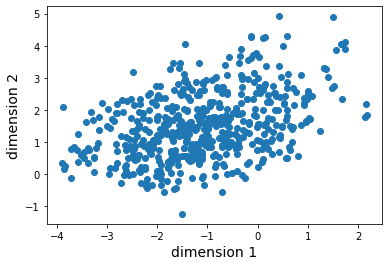

In [203]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[:2]]) for i in range(len(dstrb_sub))])
arr = X

color_dict = {1: 'red', 2:'blue'}
fig, ax = plt.subplots()

x = [arr[k][1] for k in range(len(X))]
y = [arr[k][2] for k in range(len(X))]
ax.scatter(x, y)

plt.xlabel(f'dimension 1', fontsize=14)
plt.ylabel(f'dimension 2', fontsize=14)
plt.show()

In [ ]:
dstrb_sub_2 = pd.DataFrame()

In [296]:
fwhm = 1

In [204]:
af = AffinityPropagation(random_state=15, max_iter=1000).fit(X)
cluster_labels_ini = af.labels_
initial_centers = af.cluster_centers_indices_
n_clusters_ = len(initial_centers)
print(n_clusters_)
x_cluster_label = af.predict(X)
while n_clusters_ > 7:
    af = AffinityPropagation(random_state=0).fit(X[af.cluster_centers_indices_])
    center_cluster_labels = af.labels_
    x_cluster_label = af.predict(X)
    n_clusters_ = len(af.cluster_centers_indices_)
    print(n_clusters_)
    clusters_centroids = af.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

35
6
cluster's centroids coordinates: 
 [[ 1.14457464e+00 -1.10363173e+00  5.94254434e-01  1.12447143e+00]
 [ 1.03716850e+00  1.14466675e-01  2.62696767e+00 -1.00999582e+00]
 [ 2.28597194e-01 -1.98916423e+00  1.03205168e+00  1.24983437e-01]
 [ 1.60459805e+00 -2.15094876e+00  6.49623275e-01 -9.99048173e-01]
 [-2.78819352e-04 -6.48904502e-01  1.14832485e+00  2.08898282e+00]
 [ 2.20346153e-01  1.31485724e+00  3.31358480e+00  1.76791382e+00]]


In [221]:
X2 = np.array([[X[k][1], X[k][2]] for k in range(len(X))])
dstrb_sub_2 = pd.DataFrame(X2, index=labels, columns=[1, 2])
dstrb_sub_2['cluster_lab'] = x_cluster_label

In [222]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

centroid = centeroidnp(X2)
central = closest_distance(centroid, dstrb_sub_2.drop(['cluster_lab'], axis=1))

In [223]:
aligned_buckets, aligned_rot, aligned_transl = ma.align_buckets_by_ICP_batch(buckets, central)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 198653: 100%|██████████| 550/550 [00:09<00:00, 55.19it/s]


In [241]:
MA_coords_wh = get_MA_coords(dstrb_sub_2, 1, num_subj_threshold=14, num_coord=8)
step = MA_coords_wh[1]-MA_coords_wh[0]

In [242]:
print(step)

0.6496495945113043


In [252]:
SPAM_vols, shift = ma.calc_MA_volumes_batch(MA_coords_wh, aligned_buckets, dstrb_sub_2, axis_n=1, FWHM=1)

Calculating moving averages: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


In [259]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{93}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=28)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA{x}_dim1.mesh")#### Saving of average crops

100%|██████████| 8/8 [00:00<00:00, 108.34it/s]


In [260]:
MA_coords_wh = get_MA_coords(dstrb_sub_2, 2, num_subj_threshold=14, num_coord=8)
step = MA_coords_wh[1]-MA_coords_wh[0]

In [261]:
print(step)

0.6612001700060708


In [262]:
SPAM_vols, shift = ma.calc_MA_volumes_batch(MA_coords_wh, aligned_buckets, dstrb_sub_2, axis_n=1, FWHM=1)

Calculating moving averages: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


In [263]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{93}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=28)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA{x}_dim2.mesh")#### Saving of average crops

100%|██████████| 8/8 [00:00<00:00, 10.10it/s]


In [299]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c1.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{thresh}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=5)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA{x}_cluster_1.mesh")#### Saving of average crops

100%|██████████| 5/5 [00:00<00:00, 103.02it/s]


In [300]:
MA_coords_c2 = get_MA_coords(cluster2, 1, num_subj_threshold=14)

In [301]:
SPAM_vols_c2, shift2 = ma.calc_MA_volumes_batch(MA_coords_c2, aligned_buckets_C2, cluster2, axis_n=1, FWHM=fwhm)

Calculating moving averages: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


In [302]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols_c2.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{thresh}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=5)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA{x}_cluster_2.mesh")#### Saving of average crops

100%|██████████| 5/5 [00:00<00:00, 97.01it/s]


In [303]:
MA_coords_c3 = get_MA_coords(cluster3, 1, num_subj_threshold=14)

SPAM_vols_c3, shift3 = ma.calc_MA_volumes_batch(MA_coords_c3, aligned_buckets_C3, cluster3, axis_n=1, FWHM=fwhm)

SPAM_meshes = {}
for k, volume in tqdm(list(SPAM_vols_c3.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{thresh}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=5)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA{x}_cluster_3.mesh")#### Saving of average crops

100%|██████████| 5/5 [00:00<00:00, 113.26it/s]


In [304]:
MA_coords_c4 = get_MA_coords(cluster4, 1, num_subj_threshold=14)

SPAM_vols_c4, shift4 = ma.calc_MA_volumes_batch(MA_coords_c4, aligned_buckets_C4, cluster4, axis_n=1, FWHM=fwhm)

SPAM_meshes = {}
for k, volume in tqdm(list(SPAM_vols_c4.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.3, threshold=f"{thresh}%")
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=5)
    
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA{x}_cluster_4.mesh")#### Saving of average crops

100%|██████████| 5/5 [00:00<00:00, 13.37it/s]


In [164]:
clusters_centroids

array([[-0.83357966,  2.20777   ],
       [-2.455105  ,  1.185158  ]], dtype=float32)

In [165]:
np.mean(clusters_centroids,axis=0)

array([-1.6443424,  1.6964641], dtype=float32)

In [166]:
clusters_centroids = kmeans.cluster_centers_
print(f"cluster's centroids coordinates: \n {clusters_centroids}")
centroid = np.mean(clusters_centroids, axis=0)
print(centroid)

central = closest_distance(centroid, dstrb_sub.drop(['cluster_lab'], axis=1))
print(f"Closest subject to centroid of cluster is {central}")
print(dstrb_sub[1][str(central)], dstrb_sub[2][str(central)])

cluster's centroids coordinates: 
 [[-0.83357966  2.20777   ]
 [-2.455105    1.185158  ]]
[-1.6443424  1.6964641]
Closest subject to centroid of cluster is 208226
-1.6539726 1.6252371


In [167]:
aligned_buckets, aligned_rot, aligned_transl = ma.align_buckets_by_ICP_batch(buckets, central)

>>> INFO moving_averages.transform - using 45 cores out of 48
Aligning buckets to 208226: 100%|██████████| 250/250 [00:02<00:00, 92.99it/s] 


In [168]:
MA_coords = get_MA_coords(dstrb_sub, 1, num_subj_threshold=14)
step = MA_coords[1]-MA_coords[0]

In [169]:
#SPAM_centers_c1 = [-2.05716]
#SPAM_vols_c1, shift1 = ma.calc_MA_volumes_batch(SPAM_centers_c1, aligned_buckets_C1, cluster1, axis_n=1, FWHM=1)
SPAM_vols, shift = ma.calc_MA_volumes_batch(MA_coords, aligned_buckets, dstrb_sub, axis_n=1, FWHM=0.3)

Calculating moving averages: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


In [118]:
#cld.draw(list(SPAM_vols.values())[-1], th_min=0.3)

In [119]:
#cld.draw(list(SPAM_vols.values())[0], th_min=0.3)

In [199]:
SPAM_meshes = {}

for k, volume in tqdm(list(SPAM_vols.items())[:]):
    SPAM_meshes[k]=dtx.convert.volume_to_mesh(
                    vol=volume, gblur_sigma=0.13, threshold="94%",deciReductionRate=0, smoothRate=0.25)
    #SPAM_meshes[k] = dtx.mesh.shift_aims_mesh(SPAM_meshes[k], 2*shift1[k])
    
shifted_SPAM_meshes = {}
for dist, mesh in SPAM_meshes.items():
    shifted_SPAM_meshes[str(dist)] = dtx.mesh.shift_aims_mesh_along_axis(mesh, dist, axis=0, scale=50)

100%|██████████| 5/5 [00:00<00:00, 32.28it/s]


In [200]:
for x, mesh in tqdm(shifted_SPAM_meshes.items()):
    aims.write(mesh, f"MA_{x}_2cluster44.mesh")#### Saving of average crops

100%|██████████| 5/5 [00:00<00:00, 68.25it/s]


In [113]:
fig = cld.draw(list(SPAM_vols.values())[0], th_min=0.2)
cld.draw(list(SPAM_meshes.values())[0], fig=fig)